# Data Ingestion via LanceDB

## Libraries

In [ ]:
import json
import os
import warnings
from pathlib import Path

import lancedb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from lancedb.embeddings import get_registry
from lancedb.embeddings.sentence_transformers import SentenceTransformerEmbeddings
from lancedb.pydantic import LanceModel, Vector
from lancedb.table import Table
from sentence_transformers import SentenceTransformer

from src.chunking import recursive_text_splitter, text_has_only_questions
from src.constants import LANCEDB_URI, POST_JSON_PATH, REPO_PATH, get_rag_config
from src.embeddings import EmbeddingFunction, HuggingFaceEmbedder

# ignore some warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Functions

# Parameters

In [ ]:
# paths
POST_JSON_PATH.is_dir()  # fails if it doesn't exist
LANCEDB_URI.is_dir()  # fails if it doesn't exist


# Embeddings
emb_model_name: str = get_rag_config()["embeddings"]["model_name"]
device: str = get_rag_config()["embeddings"]["device"]

# secrets
load_dotenv(REPO_PATH)
api_key = os.getenv("HF_TOKEN")

# Code

## Text Embedding



### Embedding Models
- Original Models : https://www.sbert.net/docs/sentence_transformer/pretrained_models.html
> The `all-mpnet-base-v2` model provides the best quality, while `all-MiniLM-L6-v2` is 5 times faster and still offers good quality

`multi-qa-MiniLM-L6-cos-v1`  (80MB) : "tuned for semantic search: Given a query/question, it can find relevant passages. It was trained on a large and diverse set of (question, answer) pairs."

In [ ]:
model_name = "multi-qa-MiniLM-L6-cos-v1"
test_docs = ["Hello world"]

### Load Model locally

- big package: https://stackoverflow.com/questions/77205123/how-do-i-slim-down-sberts-sentencer-transformer-library

In [ ]:
model = SentenceTransformer(model_name, device=device)

In [ ]:
model.max_seq_length

In [ ]:
embeddings01 = model.encode(test_docs).tolist()
# embeddings01

### Load Model from HuggingFace API

In [ ]:
embedder = HuggingFaceEmbedder(model_name=model_name, api_key=api_key)

In [ ]:
# slow since it's an API call
embeddings02 = embedder.embed(test_docs)
# embeddings02

In [ ]:
# compare embeddings
(1 - np.array(embeddings01) / np.array(embeddings02)).mean()

### LanceDB Embedder

In [ ]:
model_registry = get_registry().get("sentence-transformers")
model = model_registry.create(name=model_name)
model.ndims()

## Prepare data for ingestion

### Old: Function to process a single JSON file

In [ ]:
# Function to process a single JSON file


def process_json_file(file_path: Path, emb_func: EmbeddingFunction) -> pd.DataFrame:
    with open(file_path) as f:
        data: dict = json.load(f)

    # Extract the text data
    paragraphs: list[str] = data.get("paragraphs", [])
    key_takeaways: list[str] = data.get("key_takeaways", [])
    combined_text: list[str] = paragraphs + key_takeaways

    # Create embeddings for each text chunk
    embeddings: list[list[float]] = emb_func(combined_text)

    # Prepare a DataFrame
    df = pd.DataFrame(
        {
            "url": [data.get("url")] * len(combined_text),
            "title": [data.get("title")] * len(combined_text),
            "text": combined_text,
            "embedding": embeddings,
            "blog_tags": [" ".join(set(data.get("blog_tags")))] * len(combined_text),
        }
    )

    return df

In [ ]:
# using local model
emb_model = SentenceTransformer(model_name)


def emb_func(text: list[str]) -> list[list[float]]:
    return emb_model.encode(text).tolist()

In [ ]:
# Iterate over all JSON files and process them
files: list[Path] = list(POST_JSON_PATH.glob("*.json"))

all_data = []

for json_file in files[:1]:
    df = process_json_file(file_path=json_file, emb_func=emb_func)
    all_data.append(df)

In [ ]:
# with pd.option_context("display.max_colwidth", None):
#     display(df.iloc[[0]].style.set_properties(**{"text-align": "left"}))
df.iloc[[2]]

### Chunk and filter pharagraphs

In [ ]:
emb_model = SentenceTransformer(emb_model_name, device=device)

# Get the tokenizer from the model
tokenizer = emb_model.tokenizer

In [ ]:
# Iterate over all JSON files and process them
files: list[Path] = list(POST_JSON_PATH.glob("*.json"))

In [ ]:
json_file = files[0]
with open(json_file) as f:
    doc: dict = json.load(f)
paragraphs: list[str] = doc["paragraphs"]

In [ ]:
[len(tokenizer.tokenize(para)) for para in paragraphs]

In [ ]:
[text_has_only_questions(para) for para in paragraphs]

In [ ]:
[len(para) / len(tokenizer.tokenize(para)) for para in paragraphs]

In [ ]:
n_token_max: int = get_rag_config()["embeddings"]["n_token_max"]
n_char_max: int = n_token_max * 4
overlap: int = int(n_char_max * 0.1)
paragraphs_new: list[str] = []
for i, para in enumerate(paragraphs):
    if text_has_only_questions(para):
        continue
    n_token: int = len(tokenizer.tokenize(para))
    if n_token > n_token_max:
        para_chunks: list[str] = recursive_text_splitter(para, n_char_max, overlap)
        print(f"{i}: {n_token} tokens: split needed. New chunks: {len(para_chunks)}")
        paragraphs_new.extend(para_chunks)
    else:
        paragraphs_new.append(para)

print(f"Original: {len(paragraphs)} -> New: {len(paragraphs_new)}")

In [ ]:
paragraphs_new[0]

## Test Ingestion

### Test data set to ingest

In [ ]:
# file list of JSON files
files: list[Path] = list(POST_JSON_PATH.glob("*.json"))
print(f"{len(files)} JSON files are in: {POST_JSON_PATH}")

In [ ]:
test_table_data: list[dict[str, str]] = []

for json_file in files[:2]:
    with open(json_file) as f:
        doc: dict = json.load(f)
    paragraphs: list[str] = doc["paragraphs"]
    title: str = doc["title"]
    url: str = doc["url"]
    blog_tags: str = " ".join(set(doc["blog_tags"]))  # remove duplicates and join with space
    test_table_data.extend([{"text": para, "title": title, "url": url, "blog_tags": blog_tags} for para in paragraphs])

# print number of entries
print(f"{len(test_table_data)} entries")

### Method 01 : Simple: just text + vector

- following: 
    - https://lancedb.github.io/lancedb/embeddings/embedding_functions/
    - https://lancedb.github.io/lancedb/embeddings/available_embedding_models/text_embedding_functions/sentence_transformers/

In [ ]:
# Define the embedding function
emb_model: SentenceTransformerEmbeddings = get_registry().get("sentence-transformers").create(name=emb_model_name)
n_dim_vec = emb_model.ndims()


# Define the data model or schema
class DataModel(LanceModel):
    vector: Vector(dim=n_dim_vec) = emb_model.VectorField()
    text: str = emb_model.SourceField()
    title: str
    url: str
    blog_tags: str

In [ ]:
# create/connect to the database
db: lancedb.db.DBConnection = lancedb.connect(uri=LANCEDB_URI)

# create table via schema, which creates embeddings for the text column stored in the vector column
table: lancedb.table.Table = db.create_table("table01", schema=DataModel, mode="overwrite")

# add data to the table, which creates embeddings for the text column stored in the vector column
table.add(data=test_table_data)

#### testing table content

In [ ]:
# test input
table.head(2)

In [ ]:
# test simple trivial query
query = "How to reduce Heart Disease Risk"
response: list[DataModel] = table.search(query).limit(5).to_pydantic(DataModel)

# unique URLs
urls: set = {actual.url for actual in response}
print(f"{len(urls)} unique URL(s)")

# unique Titles
titles: set = {actual.title for actual in response}
print(f"{len(titles)} unique Title(s)")

print(f"{len(response)} results for: '{query}'")
for i, actual in enumerate(response):
    print(f"\t{i}. {actual.text}")

In [ ]:
resp = table.search(query).to_pydantic(DataModel)
print(f"{len(response)} results for: {query}")
resp

## Extracting Meta Data

In [ ]:
file = "/home/alex/repos/rag_nutrition_facts_blog/data/blog_posts/json/why-doctors-should-not-encourage-breast-self-exams.json"
with open(file) as f:
    data = json.load(f)

paragraphs: list[str] = data["paragraphs"]
paragraphs

In [ ]:
raw_tags: list[str] = data["raw_tags"]
tag_set: set[str] = {
    tag for tag_str in raw_tags if tag_str.startswith("tag-") for tag in tag_str.split("-")[1:] if len(tag) > 3
}
tag_set
# tags: str = ", ".join(sorted(set(tag_list)))
# tags.split(", ")  # .replace(", ", " ")
# tags_list = set(tags.replace(", ", " ").split())
# # remove string that have 3 characters or less
# tags_list = [tag for tag in tags_list if len(tag) > 3]
# tags_list

In [34]:
REPLACEMENTS: dict[str, str] = {
    "-": " ",
    ".": " ",
    ",": " ",
    "!": " ",
    "?": " ",
    "'": " ",
    '"': " ",
    "(": " ",
    ")": " ",
    "[": " ",
    "]": " ",
    "\\": " ",
    ":": " ",
    ";": " ",
    "*": " ",
    "&": " ",
    "%": " ",
    "^": " ",
    "~": " ",
    "#": " ",
    "$": " ",
    "@": " ",
    "`": " ",
}

In [ ]:
# metadata_ind: list[dict[str, str]] = {}

tags_doc = [
    list(set(chunk.lower().translate(str.maketrans(REPLACEMENTS)).split()) & set(tag_set))
    for rank, chunk in enumerate(paragraphs)
]
tags_doc

## Chunksize

In [49]:
# load database
# Testing
db = lancedb.connect(uri=LANCEDB_URI)
print(f"List of all tables in the LanceDB database: {db.table_names()}")

List of all tables in the LanceDB database: ['fulltext01', 'table01', 'table_simple01', 'table_simple02', 'table_simple03', 'table_simple04']


In [50]:
table01: Table = db.open_table("table_simple01")
print(f"Number of entries: {table01.count_rows()}")

Number of entries: 14547


In [100]:
char_counts01 = [len(text.as_py()) for text in table01.to_arrow()["text"]]

In [101]:
table03 = db.open_table("table_simple03")
char_counts03 = [len(text.as_py()) for text in table03.to_arrow()["text"]]

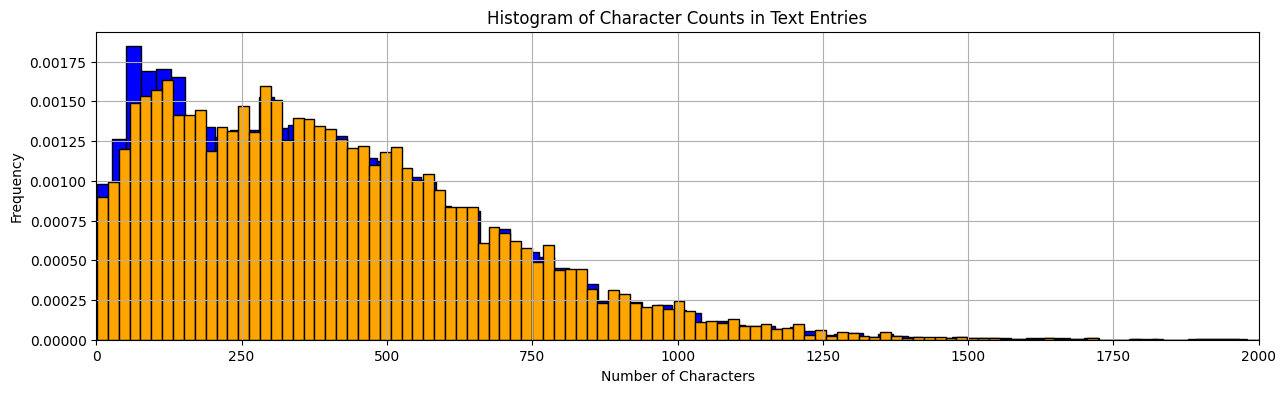

In [104]:
plt.figure(figsize=(15, 4))
plt.hist(char_counts01[:], bins=300, edgecolor="black", cumulative=False, density=True, color="blue")
plt.hist(char_counts03[:], bins=300, edgecolor="black", cumulative=False, density=True, color="orange")
plt.title("Histogram of Character Counts in Text Entries")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.xlim(0, 2000)
plt.grid(True)
plt.show()

In [87]:
def cumulative_distribution(sorted_counts):
    """
    This function takes a list of values, sorts them in descending order,
    and returns the cumulative distribution as a percentage.
    """
    # Sort the character counts in descending order
    sorted_counts = sorted(sorted_counts, reverse=True)

    # Calculate the cumulative distribution
    cumulative_distribution = np.cumsum(sorted_counts)

    # Normalize cumulative distribution to get a percentage (0-100%)
    cumulative_distribution = cumulative_distribution / cumulative_distribution[-1] * 100

    return sorted_counts, cumulative_distribution

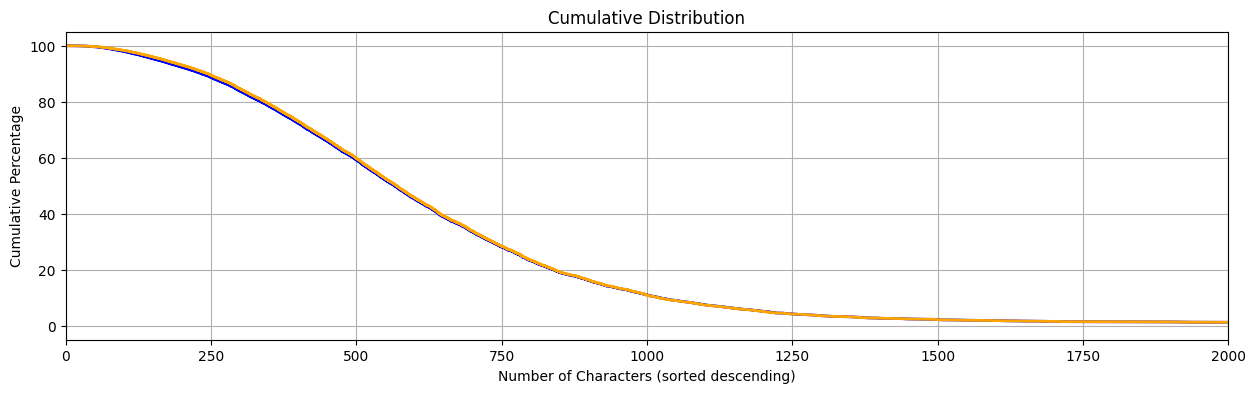

In [107]:
plt.figure(figsize=(15, 4))
plt.plot(*cumulative_distribution(char_counts01), linewidth=2, color="blue")
plt.plot(*cumulative_distribution(char_counts03), linewidth=2, color="orange")
plt.title("Cumulative Distribution")
plt.xlabel("Number of Characters (sorted descending)")
plt.ylabel("Cumulative Percentage")
plt.xlim(0, 2000)
plt.grid(True)
plt.show()

In [ ]:
# cumulative histogram but reverse